In [2]:
import pandas as pd
from pathlib import Path
import json

base_path = Path('/data/blockchain-interoperability/blockchain-social-media/twitter-data/')

spam_patterns = [
    'uniswap is being exploited'
    '200k',
    # 'http'
]

def load_df():
    # load cluster info
    cluster_ids = json.load(open(base_path/'kmeans_clusters/kmeans_init_clusters.json'))
    index_to_cluster = {
        idx:int(c_id)
        for c_id, idxs in cluster_ids.items() 
        for idx in idxs
    }

    # load sentiment
    text = pd.read_pickle(base_path / 'snapshots/whole_text.pkl').str.lower()
    sentiment = pd.read_pickle(base_path / 'sentiment/transformer/sentiment.pkl')
    sentiment_score = pd.read_pickle(base_path / 'sentiment/transformer/sentiment_score.pkl')
    timestamp = pd.to_datetime(pd.read_pickle(base_path / 'snapshots/timestamp_ms.pkl'),unit='ms').astype('datetime64[m]')


    # turn into combined dataframe
    df = pd.concat([timestamp, text, sentiment, sentiment_score],axis=1)
    df['cluster_id'] = df.index.map(index_to_cluster)

    # filter out text that contains spam tweets
    df = df[~df['whole_text'].str.contains('|'.join(spam_patterns))]
    print('loaded data!')
    return df

df = load_df()

loaded data!


In [3]:
def get_sent_stat(timestamp,subgroup):
    # print(subgroup)
    # print(subgroup.columns)
    neg_count = (subgroup['sentiment'] == -1).sum()
    neu_count = (subgroup['sentiment'] == 0).sum()
    pos_count = (subgroup['sentiment'] == 1).sum()
    (subgroup['sentiment'] + 1) / 2
    return {
        'Timestamp': timestamp,
        'Tweet Count': len(subgroup),
        'Negative Count': neg_count,
        'Neutral Count': neu_count,
        'Positive Count': pos_count,
        'Negative Ratio': neg_count / len(subgroup),
        'Neutral Ratio': neu_count / len(subgroup),
        'Positive Ratio': pos_count / len(subgroup),
        'Average Sentiment': ((subgroup['sentiment'] + 1)/2).mean(), 
        'Negative Average': subgroup[subgroup['sentiment'] == -1]['sentiment_score'].mean(),
        'Neutral Average': subgroup[subgroup['sentiment'] == 0]['sentiment_score'].mean(),
        'Positive Average': subgroup[subgroup['sentiment'] == 1]['sentiment_score'].mean(),
    }

def get_timeseries(df, interval = '30min'):
    per_delta = pd.DataFrame([get_sent_stat(t,s) for t,s in df.resample(interval, on='timestamp_ms') ])
    return per_delta


In [4]:
bad_keywords = [
    '开云体育',
    '世界杯',
    '上海',
    '上海线下',
    'gt',
    'amp',
]

overall_keywords = json.load(open(base_path/f'sentiment_keywords/cluster_whole/cluster_keywords.json'))[:10]

def load_keywords(cluster_id):
    keywords_file = base_path/f'sentiment_keywords/cluster_{cluster_id}/cluster_keywords.json'
    keywords = json.load(open(keywords_file))

    for t in bad_keywords:
        if t in keywords: keywords.remove(t)

    return [k for k in keywords if k not in overall_keywords[:10]][:10]


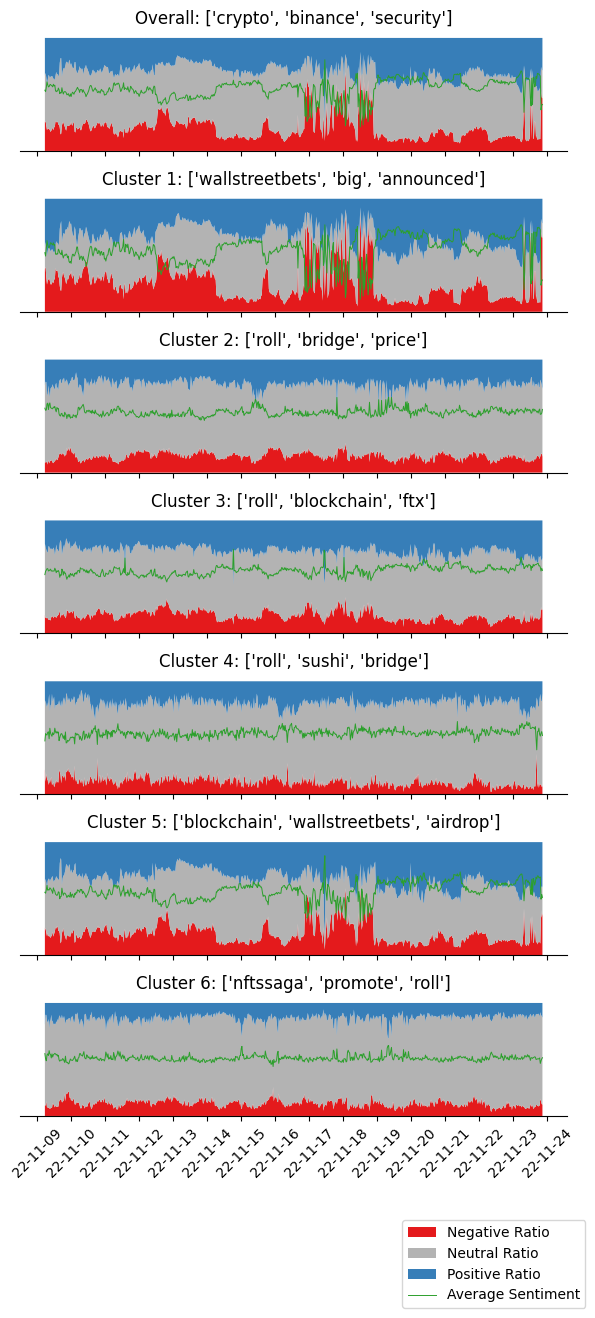

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


pos_color = sns.color_palette('Set1')[1]
neu_color = sns.color_palette('Set2')[-1]
neg_color = sns.color_palette('Set1')[0]
avg_color = sns.color_palette()[2]

cluster_ids = sorted(df['cluster_id'].unique())
# n_clusters = len÷
fig,axes = plt.subplots(nrows = len(cluster_ids) + 1, figsize= (6,12), sharex = True)


for ax, cluster_id in zip(axes.ravel(), [None]+cluster_ids): 

    if cluster_id is None: 
        per_delta = get_timeseries(df)
        plot_title = f'Overall: {overall_keywords[:3]}'
    else:
        per_delta = get_timeseries(df[df['cluster_id'] == cluster_id])
        keywords = load_keywords(cluster_id)
        plot_title = f'Cluster {cluster_id+1}: {keywords[:3]}'

    ax.stackplot(
        per_delta['Timestamp'],
        per_delta['Negative Ratio'],
        per_delta['Neutral Ratio'],
        per_delta['Positive Ratio'],
        labels = ['Negative Ratio', 'Neutral Ratio', 'Positive Ratio'],
        colors = [neg_color,neu_color,pos_color]
    )

    ax.plot(
        per_delta['Timestamp'],
        per_delta['Average Sentiment'],
        linewidth=0.7,
        color=avg_color
    )

    ax.set_title(plot_title)
    # ax.set_xticklabels(per_delta['Timestamp'].dt.strftime('%y-%m-%d'))
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


fig.legend(
    ['Negative Ratio', 'Neutral Ratio', 'Positive Ratio', 'Average Sentiment'],
    loc = 'lower right',
    bbox_to_anchor=(1,-0.1)
)
plt.xticks(rotation=45)
fig.tight_layout()


fig.savefig('../plots/sentiment/change_over_time.pdf', bbox_inches='tight')